In [1]:
!pip install torchsummary

**Задание**:

На примере датасета персонажей мультфильма Симпсонов:

1. Модифицируйте код обучения, используя различные типы LR Schedulers из Pytorch. Проведите минимум 2 эксперимента с разными шедулерами.
2. Подберите аугментации train данных, при которых итоговое качество на валидации станет сильно хуже, чем полученное на занятии.
3. Возьмите любую архитектуру (VGG, EfficientNet или MobileNet) и примените к ней методы, которые разбирались на занятии.
4. Оформите вывод по результатам проведённых экспериментов.

**Задание считается выполненным, если**:

* LR Schedulers применяются корректно, проведено 2 эксперимента
* при изменении аугментацией Accuracy сильно (> 10 процентов) уменьшилась
* корректно проведено обучение и дообучение любой сети (VGG, EfficientNet или MobileNet), получены сравнимые результаты или лучше по сравнению с практикой на занятии
* итоговый вывод содержит подробный корректный анализ проведённых экспериментов

In [2]:
import os
import time
import glob

from tqdm.notebook import tqdm
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import torch
from torch import nn
import torch.nn.functional as F
from torchsummary import summary

import torchvision
from torchvision import transforms

from IPython.display import clear_output
%matplotlib inline

sns.set(font_scale=1.2)

In [3]:
!pwd

/home/tofan/Документы/GitHub/Lesson/Уроки


In [ ]:
os.listdir("/kaggle/input/the-simpsons-characters-dataset/simpsons_dataset")

In [3]:
data_dir = "/kaggle/input/the-simpsons-characters-dataset/simpsons_dataset/simpsons_dataset"
data_image_paths = glob.glob(f"{data_dir}/*/*.jpg")
data_image_labels = [path.split('/')[-2] for path in data_image_paths]
train_files_path, val_files_path = train_test_split(data_image_paths, test_size=0.3, stratify=data_image_labels)

In [8]:
print(f"Изображений в train: {len(train_files_path)}\nИзображений в val: {len(val_files_path)}")

Изображений в train: 14653
Изображений в val: 6280


In [4]:
input_size = 224

train_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ColorJitter(0.9, 0.9, 0.9),
    transforms.RandomAffine(5),
    transforms.ToTensor(),
])


val_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
])

In [5]:
train_dataset = torchvision.datasets.ImageFolder(data_dir,transform=train_transform,is_valid_file=lambda x: x in train_files_path)

In [6]:
val_dataset = torchvision.datasets.ImageFolder(data_dir,transform=val_transform,is_valid_file=lambda x: x in val_files_path)

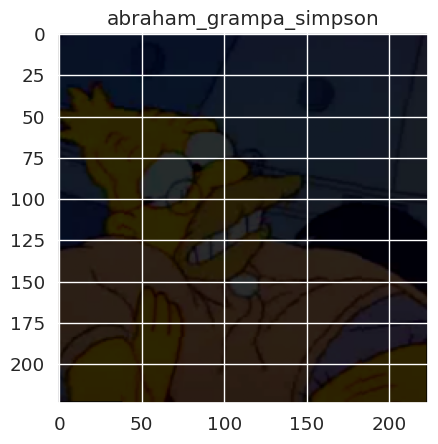

In [7]:
for i in train_dataset:
    label = i[1]
    plt.imshow(i[0].numpy().transpose(1,2,0))
    plt.title(train_dataset.classes[label])
    break

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [9]:
def plot_learning_curves(history):
    '''
    Функция для вывода графиков лосса и метрики во время обучения.
    '''
    fig = plt.figure(figsize=(20, 7))

    plt.subplot(1,2,1)
    plt.title('Лосс', fontsize=15)
    plt.plot(history['loss']['train'], label='train')
    plt.plot(history['loss']['val'], label='val')
    plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()

    plt.subplot(1,2,2)
    plt.title('Точность', fontsize=15)
    plt.plot(history['acc']['train'], label='train')
    plt.plot(history['acc']['val'], label='val')
    plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()
    plt.show()

In [20]:
def train(
    model, 
    criterion,
    optimizer, 
    train_batch_gen,
    val_batch_gen,
    num_epochs=10
):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.
    '''

    history = defaultdict(lambda: defaultdict(list))

    for epoch in range(num_epochs):
        batch_counter = 0
        train_len = len(train_files_path)
        val_len = len(val_files_path)
        
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0
        
        start_time = time.time()

        # устанавливаем поведение dropout / batch_norm  в обучение
        model.train(True) 

        # на каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in train_batch_gen:
            # обучаемся на текущем батче
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            logits = model(X_batch)
            
            loss = criterion(logits, y_batch.long().to(device))

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            train_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            train_acc += np.mean(y_batch.cpu().numpy() == y_pred)
                        
            batch_counter += 1
            percent_of_batches = batch_counter * batch_size / train_len *100
            print(f'Train -- batch {batch_counter} ready. {percent_of_batches:.2f} done')

        # подсчитываем лоссы и сохраням в "историю"
        train_loss /= len(train_batch_gen)
        train_acc /= len(train_batch_gen) 
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)
    
        # устанавливаем поведение dropout / batch_norm в режим тестирования
        model.train(False) 

        # полностью проходим по валидационному датасету  
        for X_batch, y_batch in val_batch_gen:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            logits = model(X_batch)
            loss = criterion(logits, y_batch.long().to(device))
            val_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            val_acc += np.mean(y_batch.cpu().numpy() == y_pred)
            
            percent_of_batches = batch_counter * batch_size / val_len *100
            print(f'Validation -- batch {batch_counter} ready. {percent_of_batches:.2f} done')

        # подсчитываем лоссы и сохраням в "историю"
        val_loss /= len(val_batch_gen)
        val_acc /= len(val_batch_gen) 
        history['loss']['val'].append(val_loss)
        history['acc']['val'].append(val_acc)
        
        clear_output()

        # печатаем результаты после каждой эпохи
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))
        
        plot_learning_curves(history)
        
    return model, history

In [10]:
batch_size = 64

# не забудем перемешать train
train_batch_gen = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
# валидационный датасет мешать не нужно, а точнее бессмысленно
# сеть на нём не обучается
val_batch_gen = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False
)

In [34]:
from torchvision.models import resnet18

In [35]:
model = resnet18(pretrained=False)
model.fc = nn.Linear(512, 42)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 10 of 10 took 189.010s
  training loss (in-iteration): 	1.739784
  validation loss (in-iteration): 	1.637752
  training accuracy: 			53.08 %
  validation accuracy: 			54.69 %


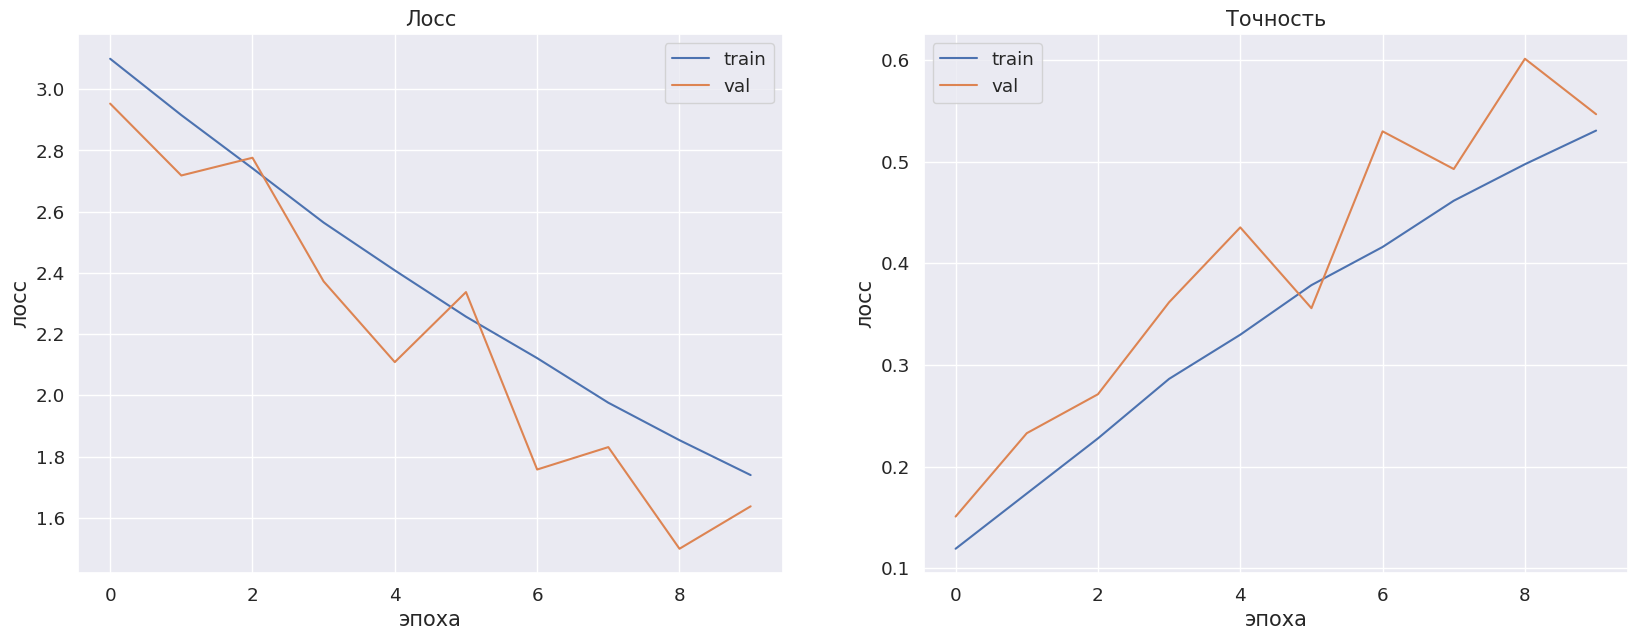

In [36]:
clf_model, history = train(
    model, criterion, optimizer, 
    train_batch_gen, val_batch_gen, 
    num_epochs=10
)

In [ ]:
plot_learning_curves(history)

# CyclicLR

In [37]:
from torch.optim.lr_scheduler import CyclicLR

In [38]:
def train_scheduler(
    model, 
    criterion,
    optimizer,
    shedulers,
    train_batch_gen,
    val_batch_gen,
    num_epochs=10
):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.
    '''

    history = defaultdict(lambda: defaultdict(list))

    for epoch in range(num_epochs):
        batch_counter = 0
        train_len = len(train_files_path)
        val_len = len(val_files_path)
        
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0
        
        start_time = time.time()

        # устанавливаем поведение dropout / batch_norm  в обучение
        model.train(True) 

        # на каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in train_batch_gen:
            # обучаемся на текущем батче
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            logits = model(X_batch)
            
            loss = criterion(logits, y_batch.long().to(device))

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            train_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            train_acc += np.mean(y_batch.cpu().numpy() == y_pred)
                        
            batch_counter += 1
            percent_of_batches = batch_counter * batch_size / train_len *100
            print(f'Train -- batch {batch_counter} ready. {percent_of_batches:.2f} done')

            # применяем шедулеры
            for sch in shedulers:
                sch.step()
        
        # подсчитываем лоссы и сохраням в "историю"
        train_loss /= len(train_batch_gen)
        train_acc /= len(train_batch_gen) 
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)
    
        # устанавливаем поведение dropout / batch_norm в режим тестирования
        model.train(False) 

        # полностью проходим по валидационному датасету  
        for X_batch, y_batch in val_batch_gen:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            logits = model(X_batch)
            loss = criterion(logits, y_batch.long().to(device))
            val_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            val_acc += np.mean(y_batch.cpu().numpy() == y_pred)
            
            percent_of_batches = batch_counter * batch_size / val_len *100
            print(f'Validation -- batch {batch_counter} ready. {percent_of_batches:.2f} done')

        # подсчитываем лоссы и сохраням в "историю"
        val_loss /= len(val_batch_gen)
        val_acc /= len(val_batch_gen) 
        history['loss']['val'].append(val_loss)
        history['acc']['val'].append(val_acc)
        
        clear_output()

        # печатаем результаты после каждой эпохи
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))
        
        plot_learning_curves(history)
        
    return model, history

In [39]:
model = resnet18(pretrained=False)
model.fc = nn.Linear(512, 42)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
schedulers = [CyclicLR(optimizer,0.01,0.05,step_size_up=20)]

Epoch 10 of 10 took 188.163s
  training loss (in-iteration): 	0.395598
  validation loss (in-iteration): 	0.716834
  training accuracy: 			88.88 %
  validation accuracy: 			80.19 %


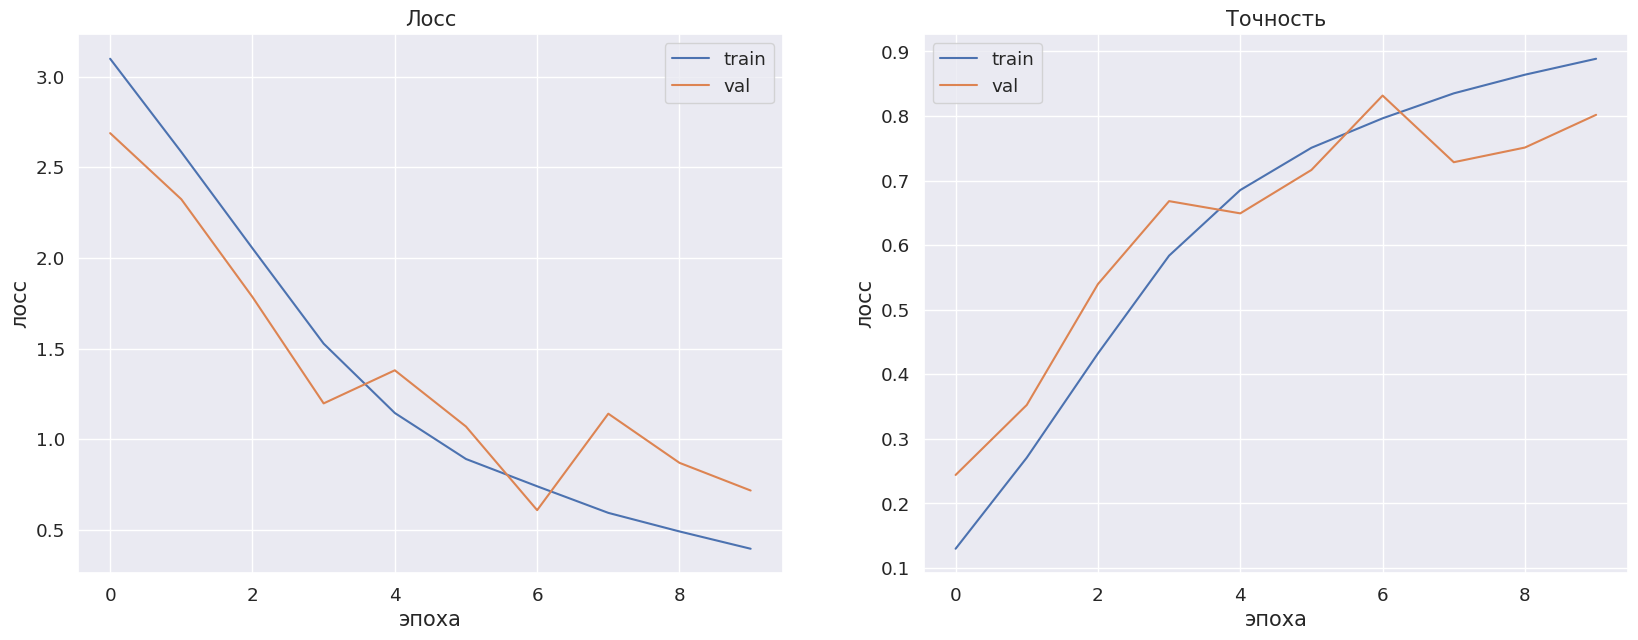

In [40]:
clf_model, history = train_scheduler(
    model, criterion, optimizer, schedulers, 
    train_batch_gen, val_batch_gen, 
    num_epochs=10
)

In [ ]:
plot_learning_curves(history)

Точность на валидации увеличилась с 55% до 80%

# StepLR

In [41]:
from torch.optim.lr_scheduler import StepLR

In [42]:
def train_scheduler_once_per_epoch(
    model, 
    criterion,
    optimizer,
    shedulers,
    train_batch_gen,
    val_batch_gen,
    num_epochs=10
):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.
    '''

    history = defaultdict(lambda: defaultdict(list))

    for epoch in range(num_epochs):
        batch_counter = 0
        train_len = len(train_files_path)
        val_len = len(val_files_path)
        
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0
        
        start_time = time.time()

        # устанавливаем поведение dropout / batch_norm  в обучение
        model.train(True) 

        # на каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in train_batch_gen:
            # обучаемся на текущем батче
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            logits = model(X_batch)
            
            loss = criterion(logits, y_batch.long().to(device))

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            train_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            train_acc += np.mean(y_batch.cpu().numpy() == y_pred)
                        
            batch_counter += 1
            percent_of_batches = batch_counter * batch_size / train_len *100
            print(f'Train -- batch {batch_counter} ready. {percent_of_batches:.2f} done')

        # применяем шедулеры
        for sch in shedulers:
            sch.step()
        
        # подсчитываем лоссы и сохраням в "историю"
        train_loss /= len(train_batch_gen)
        train_acc /= len(train_batch_gen) 
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)
    
        # устанавливаем поведение dropout / batch_norm в режим тестирования
        model.train(False) 

        # полностью проходим по валидационному датасету  
        for X_batch, y_batch in val_batch_gen:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            logits = model(X_batch)
            loss = criterion(logits, y_batch.long().to(device))
            val_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            val_acc += np.mean(y_batch.cpu().numpy() == y_pred)
            
            percent_of_batches = batch_counter * batch_size / val_len *100
            print(f'Validation -- batch {batch_counter} ready. {percent_of_batches:.2f} done')

        # подсчитываем лоссы и сохраням в "историю"
        val_loss /= len(val_batch_gen)
        val_acc /= len(val_batch_gen) 
        history['loss']['val'].append(val_loss)
        history['acc']['val'].append(val_acc)
        
        clear_output()

        # печатаем результаты после каждой эпохи
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))
        
        plot_learning_curves(history)
        
    return model, history

In [43]:
model = resnet18(pretrained=False)
model.fc = nn.Linear(512, 42)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
schedulers = [StepLR(optimizer,2,gamma=0.5)]

Epoch 10 of 10 took 204.717s
  training loss (in-iteration): 	2.465685
  validation loss (in-iteration): 	2.258168
  training accuracy: 			31.78 %
  validation accuracy: 			38.60 %


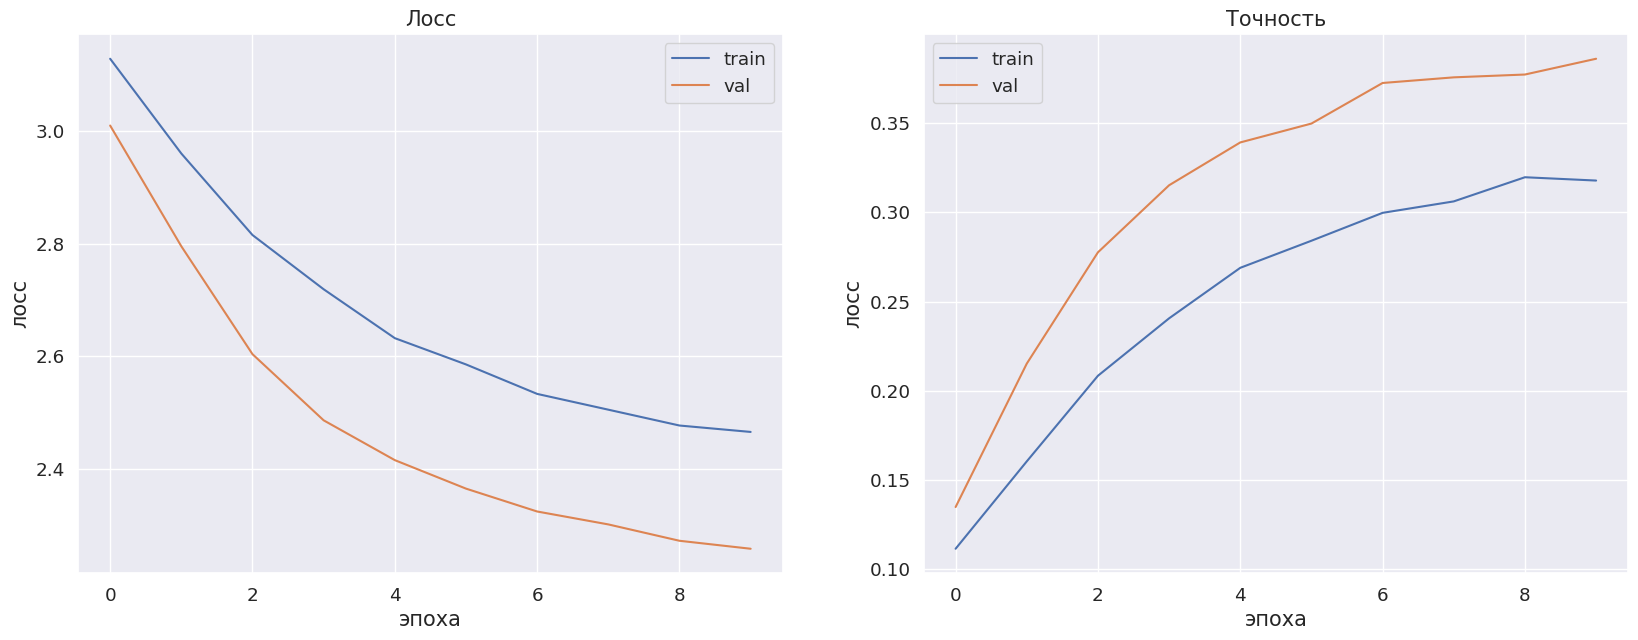

In [44]:
clf_model, history = train_scheduler_once_per_epoch(
    model, criterion, optimizer, schedulers, 
    train_batch_gen, val_batch_gen, 
    num_epochs=10
)

In [ ]:
plot_learning_curves(history)

С таким шедулером точность снизилась до 39%

# Плохая аугментация

In [45]:
input_size = 224

train_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.RandomResizedCrop(input_size,scale=(0.4,0.6)),
    transforms.ColorJitter(0.9, 0.9, 0.9),
    transforms.RandomAffine(50),
    transforms.ToTensor(),
])


val_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
])

In [46]:
train_dataset = torchvision.datasets.ImageFolder(data_dir,transform=train_transform,is_valid_file=lambda x: x in train_files_path)
val_dataset = torchvision.datasets.ImageFolder(data_dir,transform=val_transform,is_valid_file=lambda x: x in val_files_path)

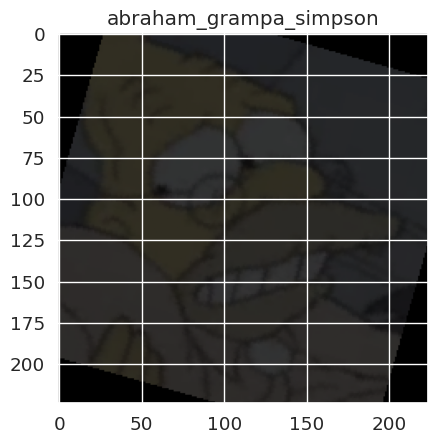

In [47]:
for i in train_dataset:
    label = i[1]
    plt.imshow(i[0].numpy().transpose(1,2,0))
    plt.title(train_dataset.classes[label])
    break

In [48]:
batch_size = 64

# не забудем перемешать train
train_batch_gen = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
# валидационный датасет мешать не нужно, а точнее бессмысленно
# сеть на нём не обучается
val_batch_gen = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False
)

In [49]:
model = resnet18(pretrained=False)
model.fc = nn.Linear(512, 42)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

Epoch 10 of 10 took 202.007s
  training loss (in-iteration): 	2.329013
  validation loss (in-iteration): 	1.987050
  training accuracy: 			34.38 %
  validation accuracy: 			44.29 %


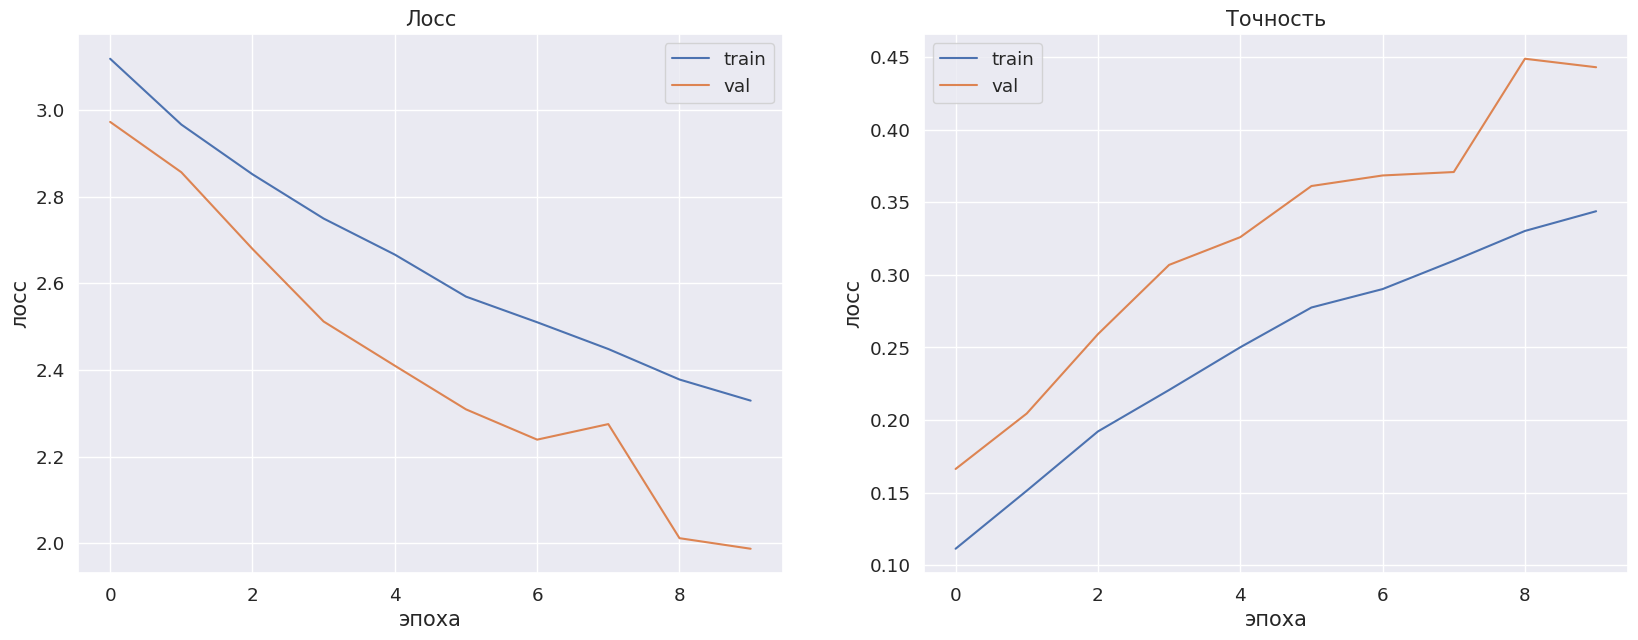

In [50]:
clf_model, history = train(
    model, criterion, optimizer, 
    train_batch_gen, val_batch_gen, 
    num_epochs=10
)

In [ ]:
plot_learning_curves(history)

Точность значительно снизилась по сравнению с эталонным тестом, потому что:
1. RandomResizedCrop обрезал слишком много
2. RandomAffine(50) - слишком большое преобразование

# mobilenet_v2

In [11]:
import torchvision as tv

In [12]:
model = tv.models.mobilenet_v2(pretrained=True)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 121MB/s] 


In [13]:
for param in model.parameters():
    param.requires_grad = False

In [14]:
for n,m in [
    ('class_ReLU_1',nn.ReLU6()),
    ('class_BatchNorm1d_1',nn.BatchNorm1d(1000)),
    ('class_Dropout_1',nn.Dropout()),
    ('class_Linear_2',nn.Linear(1000,512)),
    ('class_ReLU_2',nn.ReLU6()),
    ('class_BatchNorm1d_2',nn.BatchNorm1d(512)),
    ('class_Dropout_2',nn.Dropout()),
    ('class_Linear_3',nn.Linear(512,256)),
    ('class_ReLU_3',nn.ReLU6()),
    ('class_BatchNorm1d_3',nn.BatchNorm1d(256)),
    ('class_Dropout_3',nn.Dropout()),
    ('class_Linear_out',nn.Linear(256,42))]:
    model.classifier.add_module(n,m)

In [15]:
print("Params to learn:")
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 classifier.class_BatchNorm1d_1.weight
	 classifier.class_BatchNorm1d_1.bias
	 classifier.class_Linear_2.weight
	 classifier.class_Linear_2.bias
	 classifier.class_BatchNorm1d_2.weight
	 classifier.class_BatchNorm1d_2.bias
	 classifier.class_Linear_3.weight
	 classifier.class_Linear_3.bias
	 classifier.class_BatchNorm1d_3.weight
	 classifier.class_BatchNorm1d_3.bias
	 classifier.class_Linear_out.weight
	 classifier.class_Linear_out.bias


In [16]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
  (class_ReLU_1): ReLU6()
  (class_BatchNorm1d_1): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (class_Dropout_1): Dropout(p=0.5, inplace=False)
  (class_Linear_2): Linear(in_features=1000, out_features=512, bias=True)
  (class_ReLU_2): ReLU6()
  (class_BatchNorm1d_2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (class_Dropout_2): Dropout(p=0.5, inplace=False)
  (class_Linear_3): Linear(in_features=512, out_features=256, bias=True)
  (class_ReLU_3): ReLU6()
  (class_BatchNorm1d_3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (class_Dropout_3): Dropout(p=0.5, inplace=False)
  (class_Linear_out): Linear(in_features=256, out_features=42, bias=True)
)

In [17]:
summary(model.to(device), input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,

In [18]:
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params_to_update, lr=0.01)

Epoch 10 of 10 took 181.598s
  training loss (in-iteration): 	2.317782
  validation loss (in-iteration): 	1.572164
  training accuracy: 			38.43 %
  validation accuracy: 			59.11 %


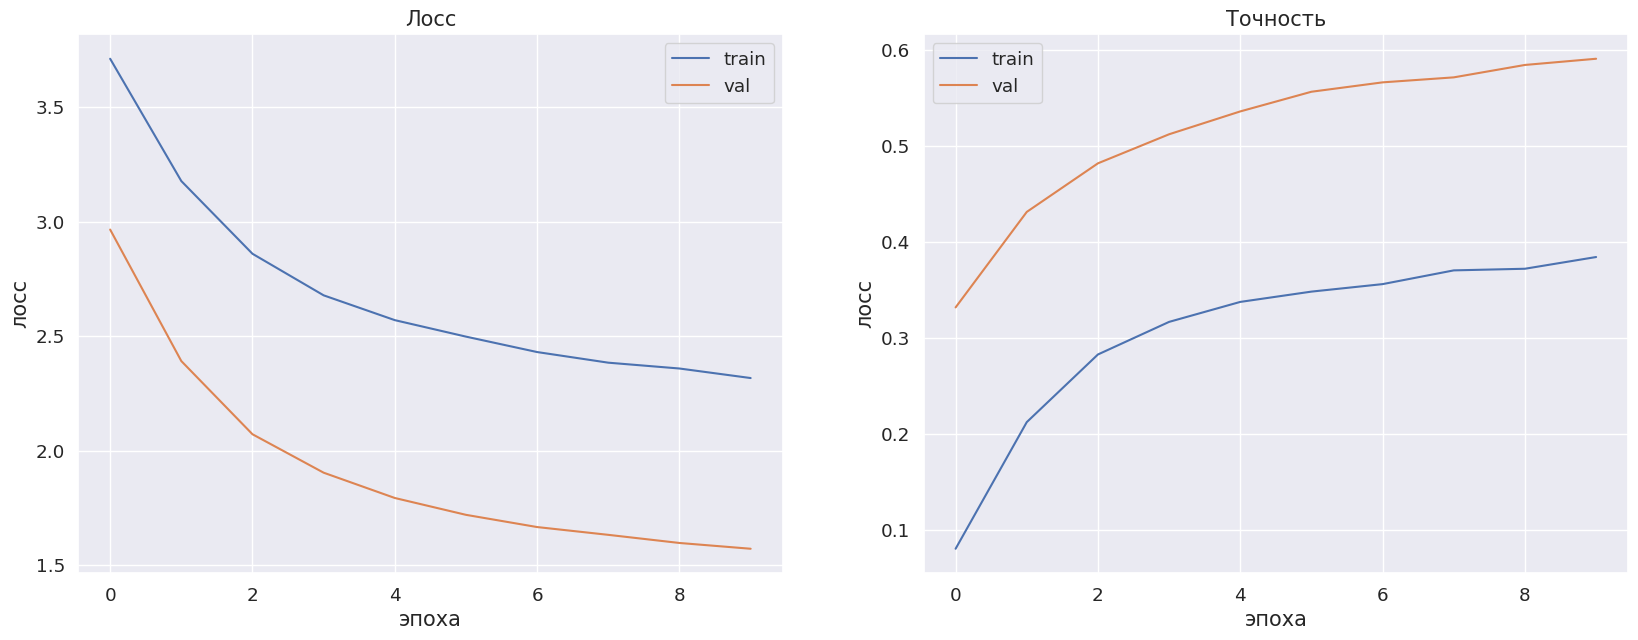

In [21]:
clf_model, history = train(
    model, criterion, optimizer, 
    train_batch_gen, val_batch_gen, 
    num_epochs=10
)

Результат по точности и времени обучения получился сопоставимый, улучшений не было. Попробуем сделать классификатор попроще.

In [29]:
model = tv.models.mobilenet_v2(pretrained=True).to(device)
for param in model.parameters():
    param.requires_grad = False
for n,m in [
    ('class_ReLU_1',nn.ReLU6()),
    ('class_BatchNorm1d_1',nn.BatchNorm1d(1000)),
    ('class_Dropout_1',nn.Dropout()),
    ('class_Linear_out',nn.Linear(1000,42))]:
    model.classifier.add_module(n,m)
summary(model.to(device), input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,

In [30]:
print("Params to learn:")
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 classifier.class_BatchNorm1d_1.weight
	 classifier.class_BatchNorm1d_1.bias
	 classifier.class_Linear_out.weight
	 classifier.class_Linear_out.bias


In [31]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params_to_update, lr=0.01)

Epoch 10 of 10 took 173.115s
  training loss (in-iteration): 	1.980780
  validation loss (in-iteration): 	1.406534
  training accuracy: 			47.12 %
  validation accuracy: 			64.52 %


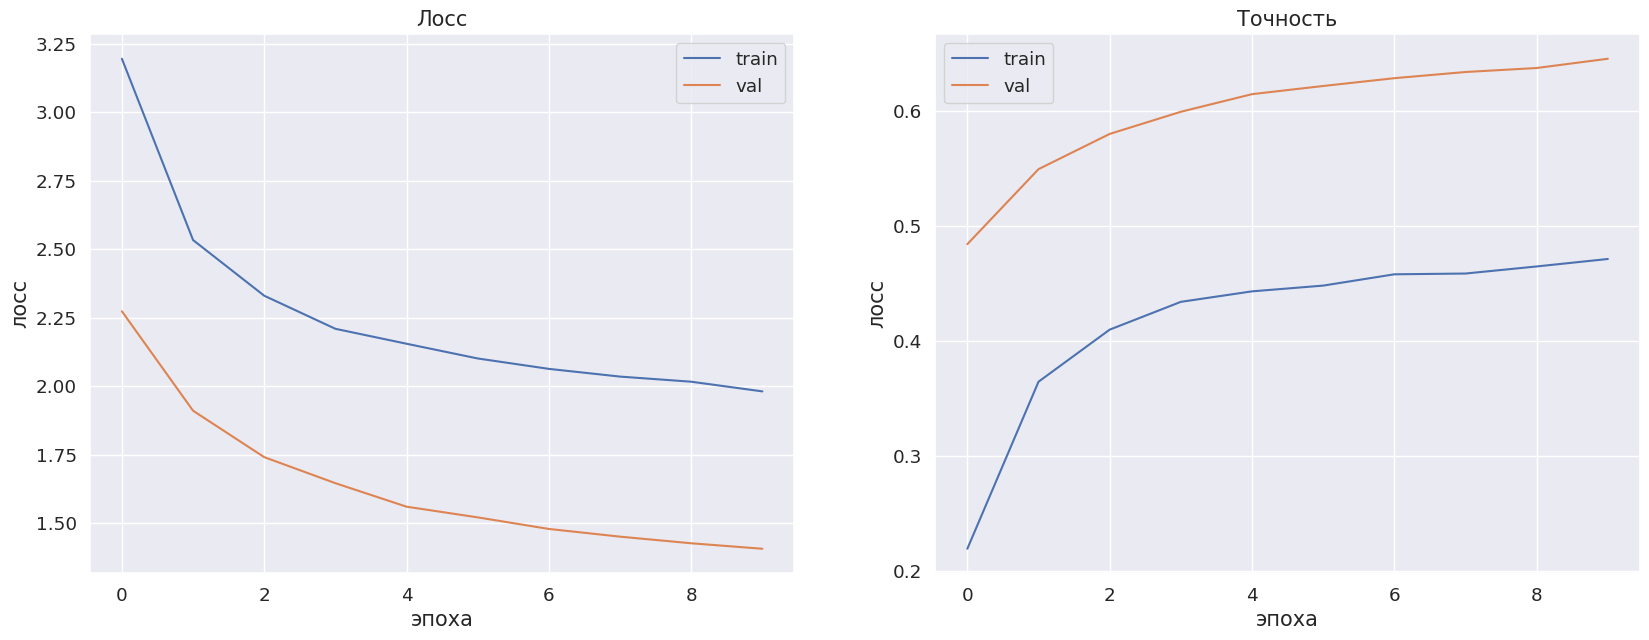

In [32]:
clf_model, history = train(
    model, criterion, optimizer, 
    train_batch_gen, val_batch_gen, 
    num_epochs=10
)

Время сопоставимо, но обучение здесь началось с более "высокого старта", и поэтому через десять эпох сеть показала более высокую точность